In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json

# Read Data

In [2]:
north_india = pd.read_csv('./data/north-india.csv')
south_india = pd.read_csv('./data/south-india.csv')
metadata = pd.read_csv('./data/metadata.csv')
with open('./output/output.json') as json_file:
    codebook = json.load(json_file)

## Draw from Google Sheets

In [3]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# Reference: https://developers.google.com/sheets/api/quickstart/python
def read_google_sheets(SPREADSHEET_ID, RANGE_NAME, HEADER_RANGE):
    creds = None
    # autogenerated
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                range=RANGE_NAME).execute()
    
    header = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                               range=HEADER_RANGE).execute()
    
    header_values = header.get('values', [])
    values = result.get('values', [])
    
    return values, header_values

SPREADSHEET_ID = '1AjynK9mMQTw58B_B8b_ZIip3fyUm-aoV7Pp21HziBb0'
RANGE_NAME = 'canto_codings!A2:AT'
HEADER_RANGE = 'canto_codings!A1:AT1'

data, header = read_google_sheets(SPREADSHEET_ID, RANGE_NAME, HEADER_RANGE)

canto_codings = pd.DataFrame(data, columns = header[0])

## Utility Functions

In [4]:
def find_canto_features(canto_coding_id):
    for i,row in canto_codings.iterrows():
        if(str(canto_coding_id) == row['canto_coding_id']):
            return row

In [5]:
def get_canto_metadata(canto_coding_id):
    for i, row in metadata.iterrows():
        if(str(canto_coding_id) == row['C-id']):
            return row

In [6]:
def get_display_code(line, binary_code):
    line = codebook['line_'+str(line)]
    for encoding in line:
        if encoding['code'] == str(binary_code):
            return encoding['display_code']

# Prepare Output Data Structure

In [7]:
columns = ["canto_coding_id", "region", "division","subregion", "area_kingdom", "culture", "lat", "lng"]

for i in range(37):
    columns.append("cv_"+str(i+1))
    
north_india_full = pd.DataFrame(columns=columns)
south_india_full = pd.DataFrame(columns=columns)

# Connect Everything

In [8]:
def main(input_matrix, output_matrix):
    for i, row in input_matrix.iterrows():
        canto_coding_id = row['canto_coding_id']
        culture = row['place']
        meta = get_canto_metadata(int(canto_coding_id))
        lat = meta['Local_lat']
        lng = meta['Local_long']
        region = meta['Region']
        division = meta['Division']
        subregion = meta['Subregion']
        area = meta['Area/Kingdom']
        canto = find_canto_features(canto_coding_id)
        canto_data = []
        for i in range(37):
            canto_data.append(get_display_code(i+1, canto["cv_"+str(i+1)]))
        new_row = pd.DataFrame([[
            canto_coding_id,
            region,
            division,
            subregion,
            area,
            culture,
            lat,
            lng,
            canto_data[0],
            canto_data[1],
            canto_data[2],
            canto_data[3],
            canto_data[4],
            canto_data[5],
            canto_data[6],
            canto_data[7],
            canto_data[8],
            canto_data[9],
            canto_data[10],
            canto_data[11],
            canto_data[12],
            canto_data[13],
            canto_data[14],
            canto_data[15],
            canto_data[16],
            canto_data[17],
            canto_data[18],
            canto_data[19],
            canto_data[20],
            canto_data[21],
            canto_data[22],
            canto_data[23],
            canto_data[24],
            canto_data[25],
            canto_data[26],
            canto_data[27],
            canto_data[28],
            canto_data[29],
            canto_data[30],
            canto_data[31],
            canto_data[32],
            canto_data[33],
            canto_data[34],
            canto_data[35],
            canto_data[36],
        ]], columns = columns)
        output_matrix = output_matrix.append(new_row)
    return output_matrix

In [9]:
north_india_full = main(north_india, north_india_full)

In [10]:
south_india_full = main(south_india, south_india_full)

In [11]:
north_india_full.to_csv('./data/north_india_full.csv', index=False)
south_india_full.to_csv('./data/south_india_full.csv', index=False)

In [12]:
region = []
for i in range(len(north_india_full)):
    region.append("North")
for i in range(len(south_india_full)):
    region.append("South")

frames = [north_india_full, south_india_full]
all_india_full = pd.concat(frames)
all_india_full["region"] = region
all_india_full.to_csv('./data/all_india_full.csv', index=False)

# Map Plot

In [9]:
#read from csv
all_india_full = pd.read_csv('./data/all_india_full.csv')

dropped = []
for i in range(37):
    dropped.append("cv_"+str(i+1))
dropped_2 = ["canto_coding_id"]
for item in dropped_2:
    dropped.append(item) 
places = all_india_full.drop(columns=dropped)
places['count'] = places.groupby('culture')['culture'].transform('count')

exist = []
lat = []
lng = []
count = []
region = []
locations = pd.DataFrame()
for i, row in places.iterrows():
    if row["culture"] not in exist:
        exist.append(row["culture"])
        lat.append(row["lat"])
        lng.append(row["lng"])
        count.append(row["count"]*300)
        region.append(row["region"])
    else:
        pass
locations["culture"] = exist
locations["lat"] = lat
locations["lng"] = lng
locations["count"] = count
locations["region"] = region

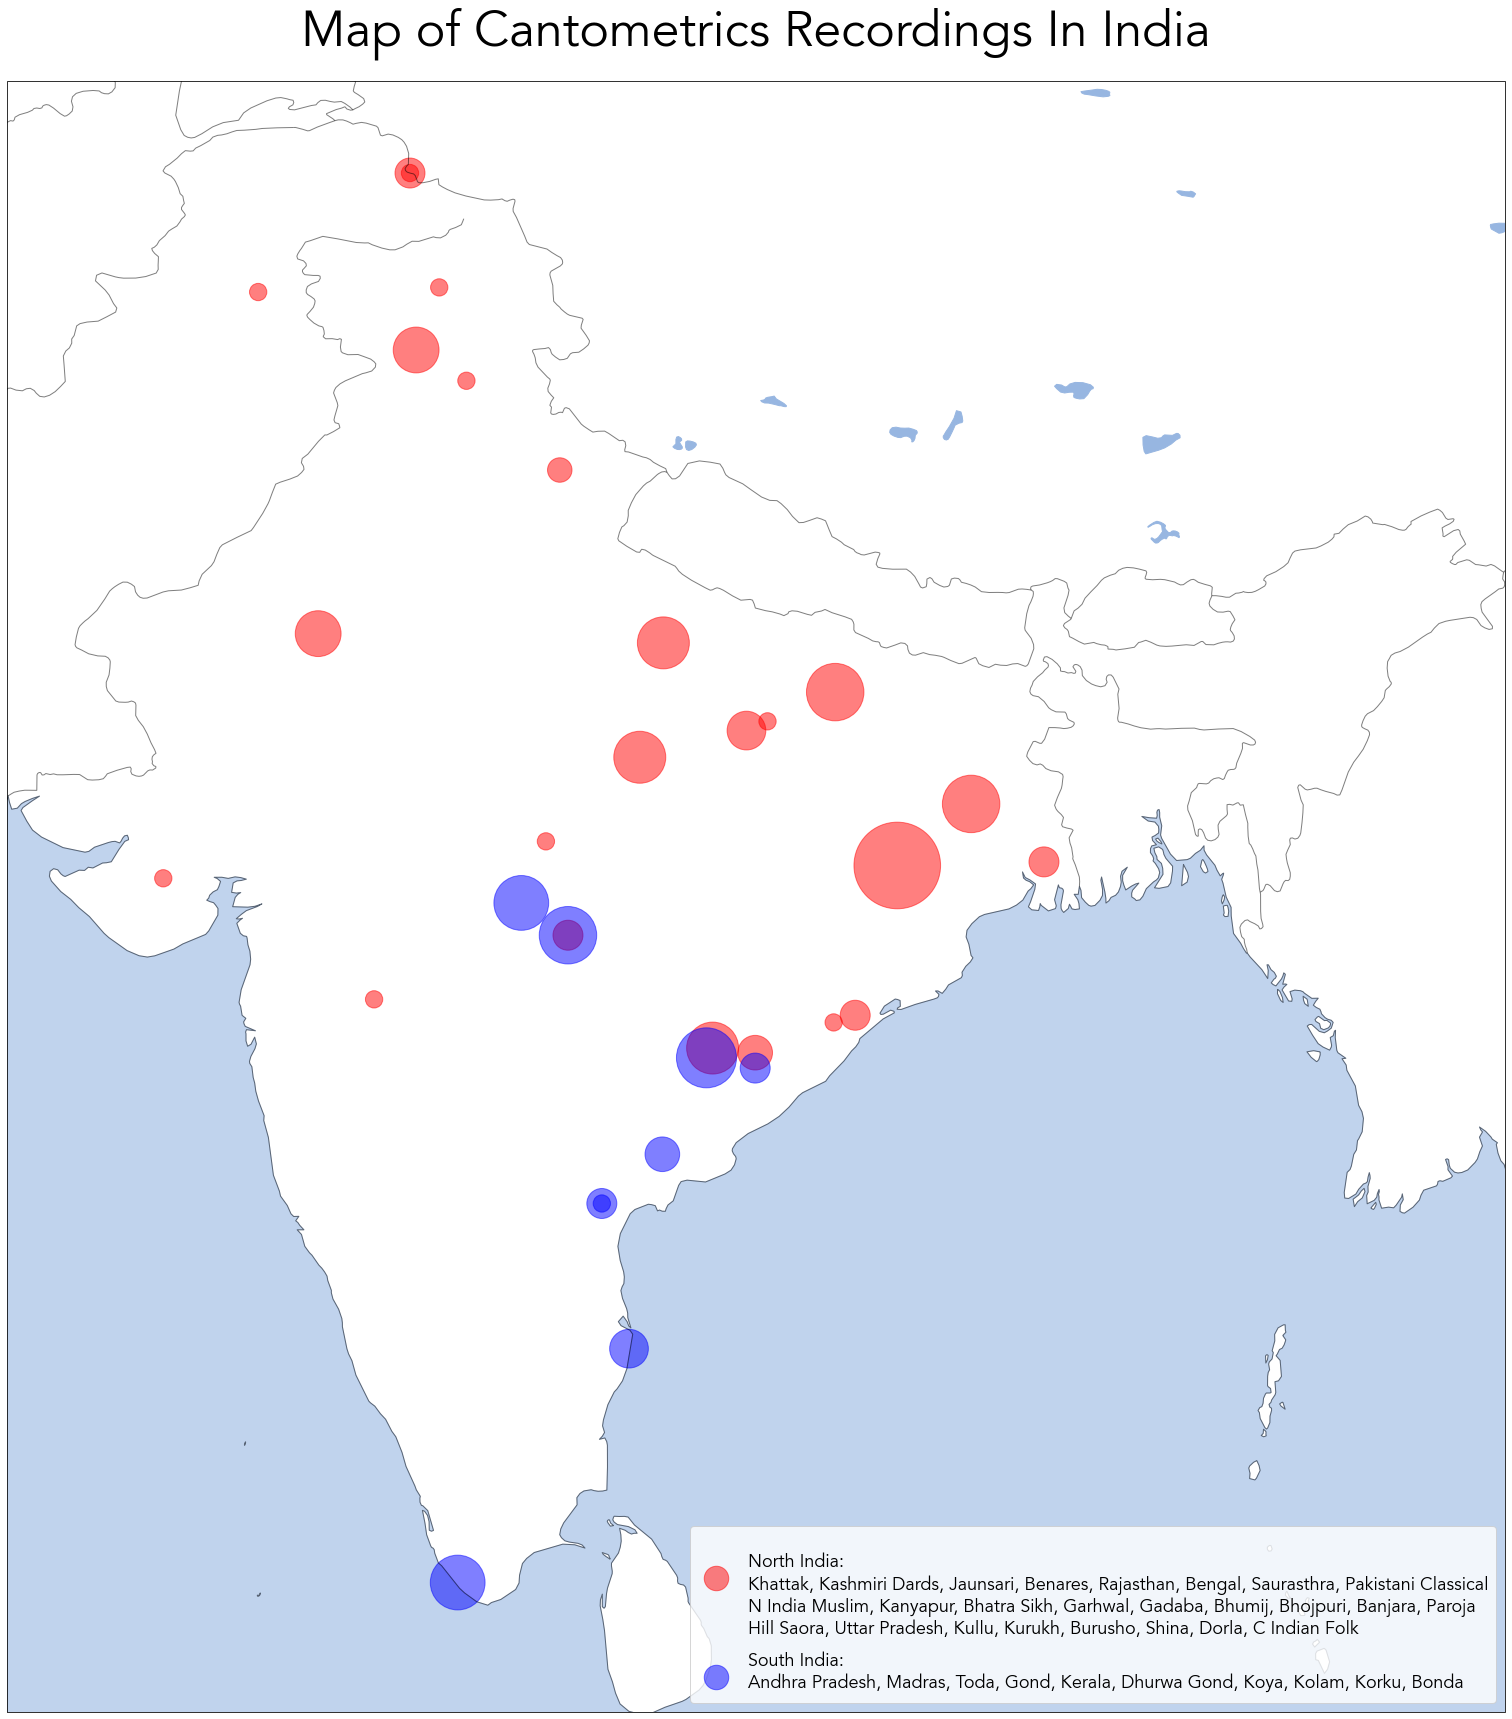

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cartopy.feature as cfeature
from random import random

%matplotlib inline

categories = np.unique(locations['region'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Avenir'})
plt.rcParams.update({'axes.titlepad': 36.0})
locations["Color"] = locations['region'].apply(lambda x: colordict[x])
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([68.14712,97.34466, 6, 37.090000])
north = locations.iloc[:24]
south = locations.iloc[24:]

north_label = "North India: "
south_label = "South India:\n"
for i, text in enumerate(north["culture"]):
    if i % 8 ==0:
        north_label+= "\n"+text
    else:    
        north_label+=", "+text
for i, text in enumerate(south["culture"]):
    if i==0:
        south_label+=text
    else:
        south_label+=", "+text
ax.scatter(north.lng, north.lat, c="r", label=north_label, s=north["count"], alpha=.5)
ax.scatter(south.lng, south.lat, c="b", label=south_label, s=south["count"], alpha=.5)

# for i, location in enumerate(locations['count']):
#     ax.annotate(str(int(location/300)), (locations.loc[i, 'lng'],locations.loc[i, 'lat']+(random()*1)), fontsize=28)

lgnd = ax.legend(loc="lower right", labelspacing=2.0, fontsize=18.0)
plt.title("Map of Cantometrics Recordings In India", fontsize=50)
for i in range(2):
    lgnd.legendHandles[i]._sizes = [600]
for txt in lgnd.get_texts():
    txt.set_va("center")
    txt.set_y(18)
ax.coastlines(alpha=.5)
ax.add_feature(cfeature.BORDERS, alpha=.5)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN, alpha=.6)
plt.savefig('./figs/map.png')

# World Map Plot

In [11]:
metadata = pd.read_csv('./data/metadata.csv')

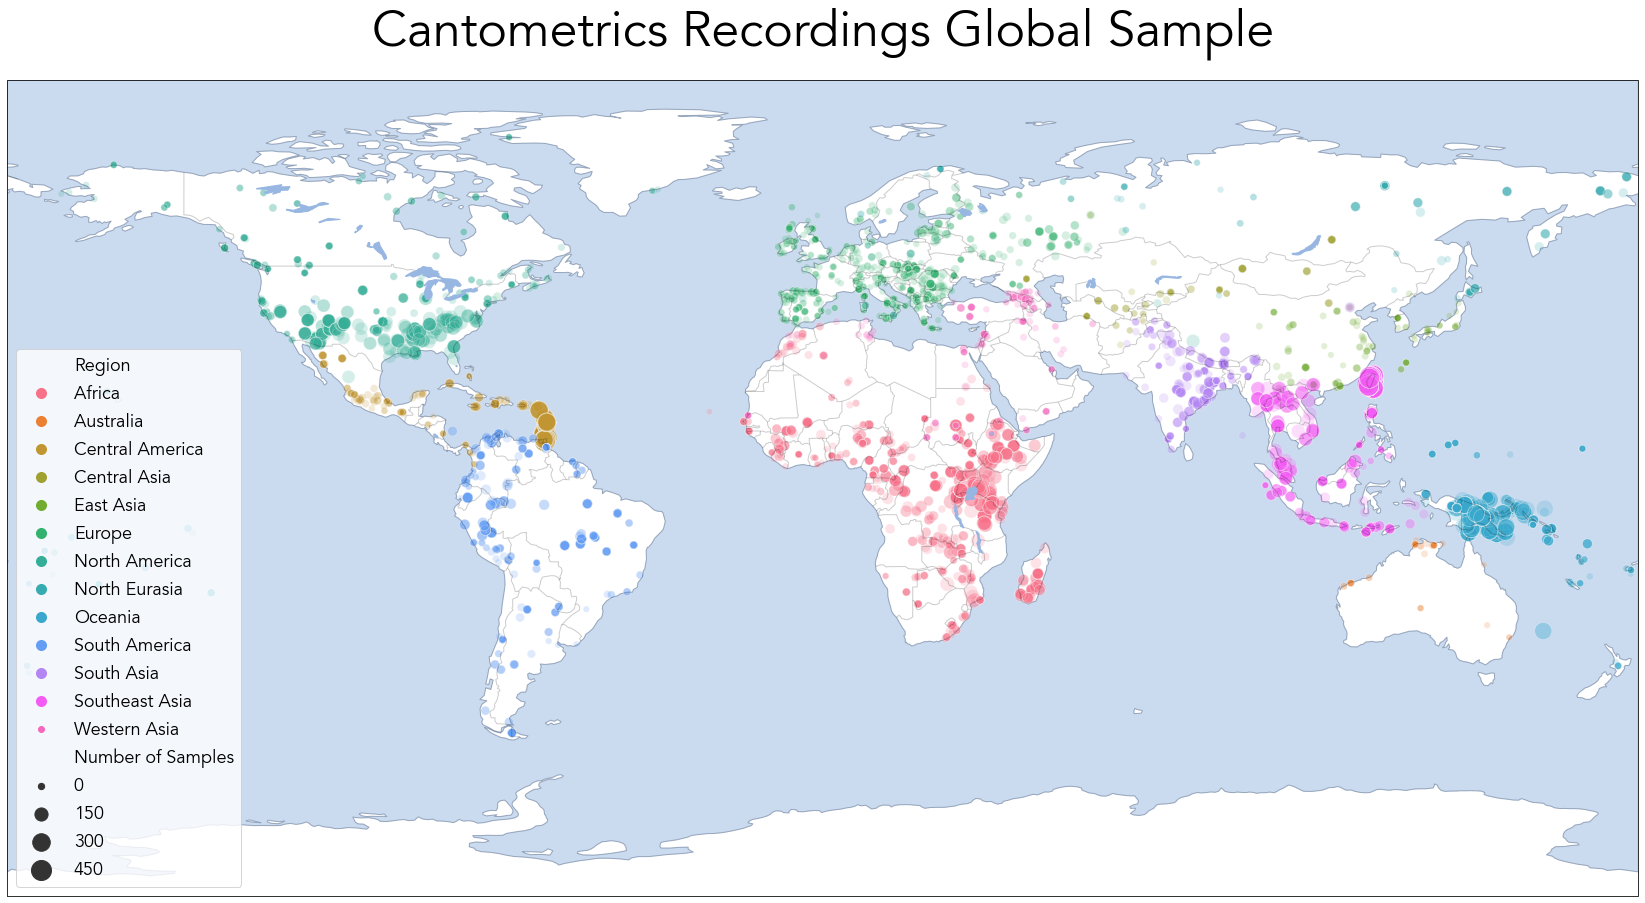

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(30,15))


x = []
y = []
for i, row in metadata['Local_long'].iteritems():
    x.append(float(row))
    
for i, row in metadata['Local_lat'].iteritems():
    try:
        if row =='19,27':
            y.append(19.27)
        elif row == ' ':
            y.append(40.7410861)
        else:
            y.append(float(row))
    except ValueError as e:
        print(i, e)

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Avenir'})
plt.rcParams.update({'axes.titlepad': 36.0})

ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_global()

# grouped_df = metadata.drop_duplicates(subset = ["Region"])
# grouped_df['count'] = 5*metadata.groupby('Region')['C-id'].transform('count')
# grouped_df.to_csv('./data/grouped.csv')
# grouped_df = pd.read_csv('./data/grouped.csv')
# groups = grouped_df.groupby('Region')

# for name, group in groups:
#     ax.scatter(group['Local_long'], group['Local_lat'], s=group['count'], alpha=.5, label=name)
#     for i,txt in enumerate(group['count']):
#         ax.annotate(str(int(txt/5)), (group['Local_long'].item(), group['Local_lat'].item()+3))

metadata['Number of Samples'] = metadata.groupby('Subregion')['C-id'].transform('count')
g = sns.scatterplot(x, y, hue=metadata['Region'], alpha=.2, size=metadata['Number of Samples'], sizes=(40, 400))
lgnd = ax.legend(loc="lower left", markerscale=1.0)
for i in range(13):
    lgnd.legendHandles[i]._sizes = [100]

ax.coastlines(alpha=.2)
ax.add_feature(cfeature.BORDERS, alpha=.2)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN, alpha=.5)


plt.title("Cantometrics Recordings Global Sample", fontsize=50)
plt.savefig("./figs/world.png")

# Preparing Data for AMOVA for Indian Sample in R

## Removing Cultures With Only One Sample

In [17]:
all_india_full['Number of Samples'] = all_india_full.groupby('culture')['culture'].transform('count')
singles = all_india_full[all_india_full['Number of Samples']!=1]
singles.to_csv('./data/indian_no_singles.csv')

## Samples Dataframe

In [18]:
sample_columns = all_india_full['culture'].unique()
sample_columns = np.insert(sample_columns, 0, 'canto_coding_id', axis=0)
samples = pd.DataFrame(columns=sample_columns)
## fill this up with zeros

for i, row in all_india_full.iterrows():
    samples.loc[i, row['culture']] = 1
    samples.loc[i, 'canto_coding_id'] = row["canto_coding_id"]
samples = samples.fillna(0)
samples.to_csv('./data/samples.csv')

## Structures Dataframe

In [19]:
structure_list = []
for i in range(len(sample_columns)-1):
    structure_list.append(all_india_full[all_india_full['culture']==sample_columns[i+1]]['region'].all())
structure = pd.DataFrame(structure_list, columns = ['region'])
structure.to_csv('./data/structure.csv')

# Prepare AMOVA Data for Global Sample in R
## Remove cultures with Only One Sample

In [20]:
canto_codings['Number of Samples'] = canto_codings.groupby('Culture')['Culture'].transform('count')
singles = canto_codings[canto_codings['Number of Samples']!=1]
singles.to_csv('./data/global_no_singles.csv')

## Appending regions to the canto_codings dataframe

In [21]:
canto_codings['region'] = metadata['Region']

## Samples Dataframe
### This will take a while to run

In [22]:
sample_columns = singles['Culture'].unique()
sample_columns = np.insert(sample_columns, 0, 'canto_coding_id', axis=0)
samples = pd.DataFrame(columns=sample_columns)
## fill this up with zeros

for i, row in singles.iterrows():
    samples.loc[i, row['Culture']] = 1
    samples.loc[i, 'canto_coding_id'] = row["canto_coding_id"]
samples = samples.fillna(0)
samples.to_csv('./data/global_samples.csv')

## Structures Dataframe

In [23]:
structure_list = []
for i in range(len(sample_columns)-1):
    structure_list.append(canto_codings[canto_codings['Culture']==sample_columns[i+1]]['region'].all())
structure = pd.DataFrame(structure_list, columns = ['region'])
structure.to_csv('./data/global_structure.csv')

# PCA

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

In [14]:
india_pca = pd.read_csv('./data/india_pca.csv')

In [15]:
codings = india_pca

In [16]:
features = ['cv_'+str(i+1) for i in range(37)]
# Separating out the features
x = codings.loc[:, features].values
x = StandardScaler().fit_transform(x)
y = codings.loc[:,['region']].values

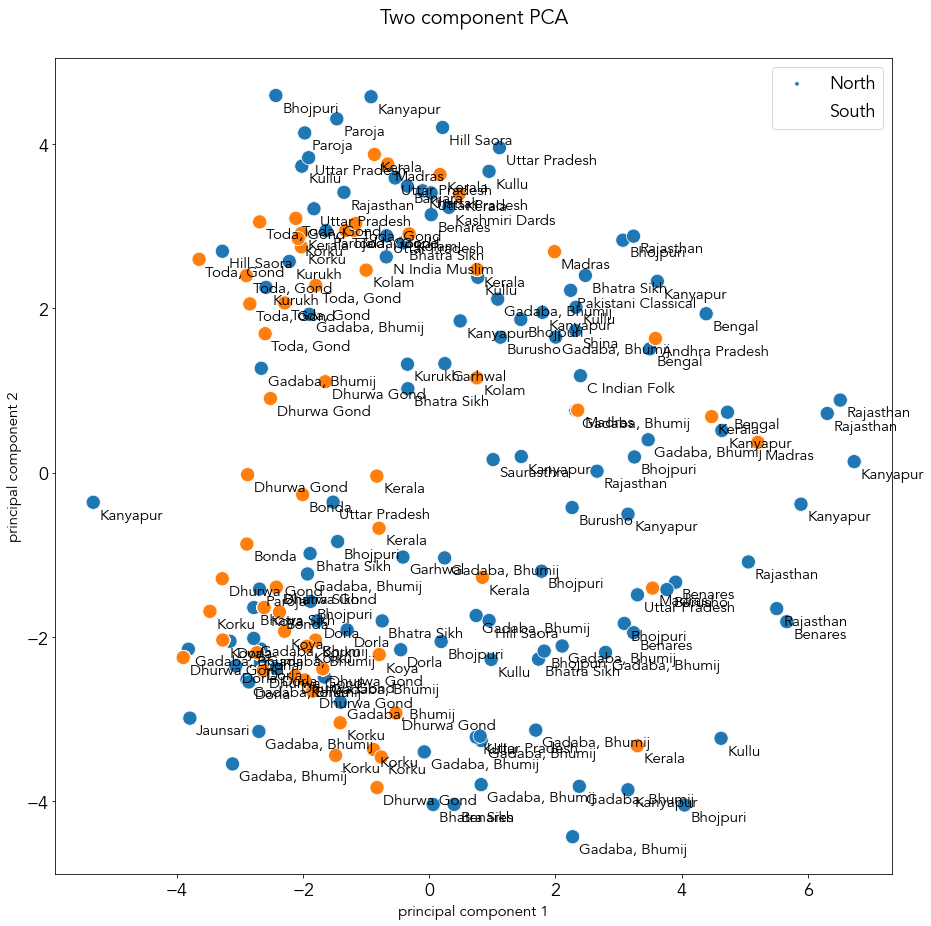

In [17]:
x = np.nan_to_num(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, codings['region']], axis = 1)
colors = cm.get_cmap('viridis', 9232)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA', fontsize = 20)
targets = codings['region']
for target, color in zip(targets,colors.colors):
    indicesToKeep = finalDf['region'] == target
    p1 = sns.scatterplot(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'], hue=targets, s=200)

#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , cmap = color
#                , s = 200)


for line in range(0,codings.shape[0]):
     p1.text(finalDf.loc[line, 'principal component 1']+0.1, finalDf.loc[line, 'principal component 2']-0.2, codings.loc[line, 'culture'], horizontalalignment='left', size='small', color='black', weight='light')
 

lgnd = ax.legend(targets.unique(), loc="upper right")
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])

plt.rcParams.update({'font.size': 12})
plt.savefig("./figs/india_pca.png")

In [18]:
pca.explained_variance_

array([6.57363421, 6.07008539])

In [19]:
pca.explained_variance_ratio_

array([0.17667324, 0.16313985])